### Etudiant 1: GIANG Phuong-Thu, Cécile (3530406)
### Etudiant 1: KHALFAT Célina (28716860)

# TME 3 - Chargement de données, GPU et checkpointing

Dans ce TME, nous finissons notre revue de PyTorch en montrant comment :
- définir des classes permettant de représenter les données d’apprentissage
- passer sur GPU
- faire en sorte de pouvoir reprendre un apprentissage après une interruption volontaire ou non (checkpointing)

Les données utilisées tout le long de ce TME sont la _base de chiffres manuscrites **MNIST**_.

## 1 - Gérer les données avec `Dataset` et `DataLoader`

Nous implémentons une classe `MNISTDataset` héritant de `Dataset`. Cette classe nous permettra de manipuler le jeu de données MNIST. En particulier:
- la méthode `__getitem__` nous permet de récupérer un couple (exemple, label) dans notre base de données
- la méthode `__len__` renvoie la taille du jeu de données

Nous chargeons ensuite nos données d'apprentissage et de test dans une instance de Dataloader qui est un itérateur sur nos données, et qui permet de spécifier la taille des batchs, s'il faut mélanger ou pas les données et de charger les données en parallèle

Afin de pouvoir par la suite comparer des résultats de différentes fonctions appliquées sur nos données, nous donnons en paramètre de nos `DataLoader` une graine afin de toujours séparer nos données en les mêmes batchs.

## 2 - Implémentation d'un auto-encodeur

Nous implémentons une classe `AutoEncoder` héritant de la classe `Module` fournie par `PyTorch`, et qui suit l'architecture suivante: `linéaire → ReLU` pour la partie codage, et `linéaire → sigmoide` pour la partie décodage.

## 3 - Campagne d'expériences sur l'auto-encodeur

Nous définissons maintenant une fonction `autoencoding_neuralnet` prenant en paramètre la dimension de l'espace latent dans lequel projeter nos données pour la partie codage. Cette fonction effectuera un apprentissage sur notre auto-encodeur afin de minimiser le coût **BCE** _(Binary Cross-Entropy)_ entre les images de notre base MNIST et les reconstructions faites par notre réseau lors de la phase forward.

En particulier, nous spécifions à notre fonction de charger les données et notre modèle en GPU si celui-ci est disponible afin d'accélérer nos calculs. Nous faisons également attention à sauvegarder au fur et à mesure de l’apprentissage notre modèle afin
par exemple de pouvoir reprendre les calculs en cas d’interruption _(checkpointing)_.

Nous observons les loss en apprentissage et en test pour différentes valeurs de dimensions latentes.

**Projection dans un espace de dimension 32:**

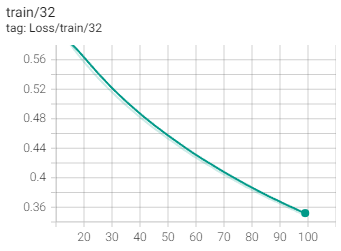
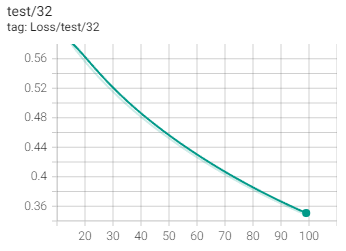


**Projection dans un espace de dimension 64:**

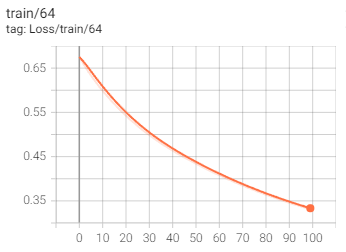
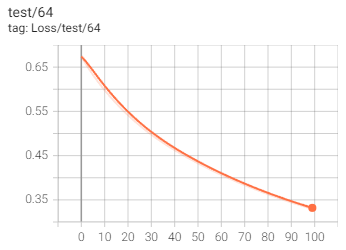


**Projection dans un espace de dimension 128:**

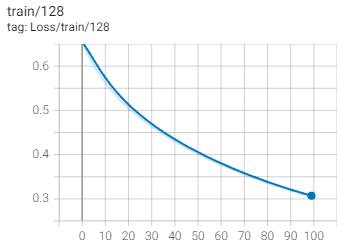
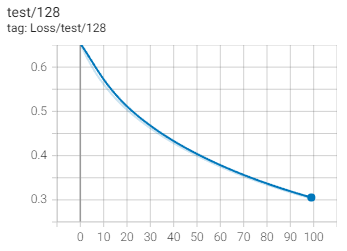

**Projection dans un espace de dimension 256:**

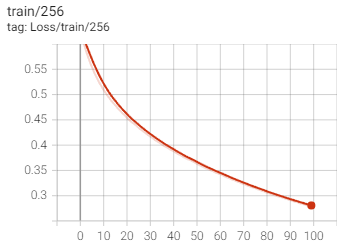
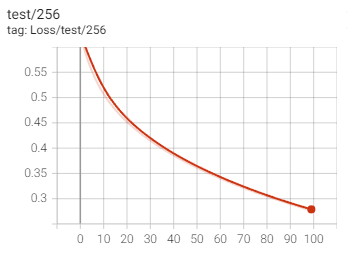

Nous observons que plus l'espace de projection est grand, plus la loss est faible: la perte d'information lors du passage en petite dimension est bien moins important lorsque nous conservons un grand nombre de descripteurs.

**Images reconstruites**


Ci-dessous nous affichons de gauche à droite une image issue de la base MNIST, puis ses reconstructions pour des espaces latents de respectivement 32, 64, 128 et 256.

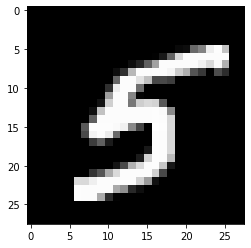
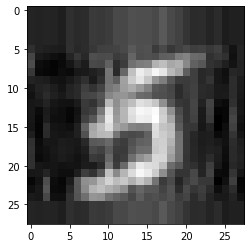
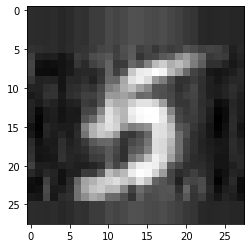
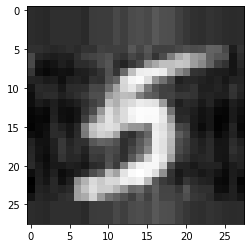
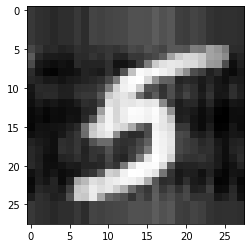

 
 Les images obtenues viennent confirmer nos observations ci-dessus: les images reconstruites après projection sur des espace de plus grande dimension se rapprochent bien plus de l'image originale.

## 4 - Highway Network

Un problème posé par des réseaux de neurones à couches multiples est qu'ils peuvent être sujets à ce qu'on appelle le _**vanishing gradient problem**_ (problème de dissipation du gradient): plus un réseau contient de couches, plus le gradient de la loss se dissipe lors de la phase de backpropagation à travers ces différentes couches. Au final, le gradient devient presque nul et il n'y a quasiment aucune mise à jour sur les paramètres à optimiser.

Pour palier à ce problème, l'article ci-dessous introduit le concept de **Highway Network**:
https://arxiv.org/pdf/1505.00387.pdf

Au lieu de considérer un réseau classique où un module $H$ (donc une couche de notre réseau) correspond à une transformation affine suivie d'une activation non-linéaire, nous définissons maintenant pour chaque couche deux transformations non-linéaires supplémentaires que nous noterons $T$ _(transform gate)_ et $C$ _(carry gate)_. En règle générale, nous prendrons $C = 1 - T$.

La sortie de chaque couche est désormais définie ainsi:
$$ y = H(x,w_H)· T(x,w_T) + x · (1 − T(x,w_T)) $$

Nous comprenons donc que les transformations $T$ et $C$ permettent de déterminer à quel point nous prenons en compte la transformation $H$: plus $T$ est proche de 1, plus la sortie correspond à la transformation $H(x,w_H)$. Au contraire, plus $T$ est proche de 0, plus $C$ tend vers 1 et donc aucune tranformation n'est appliquée à l'entrée $x$: la couche ne fait que laisser passer $x$.

Nous implémentons maintenant une classe `Highway` héritant de la classe `Module`.

Nous fixerons ainsi nos différentes transformations:
- $H$ est une transformation linéaire suivie d'une activation ReLU
- $T$ est une transformation linéaire suivie de la fonction non-linéaire sigmoïde
- $C$ correspond à $1 - T$

## 3 - Campagne d'expériences sur Highway Network

Nous testons notre réseau sur différents nombres de couches. 

Nous définissons une fonction `highway_neuralnet` prenant en paramètre le nombre de couches de notre réseau de neurones. La loss à minimiser est là encore **BCE**.

**Highway Network à 5 couches:**

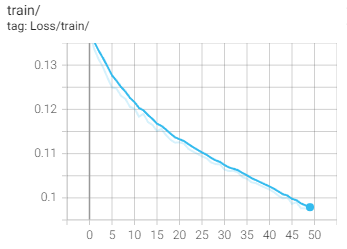
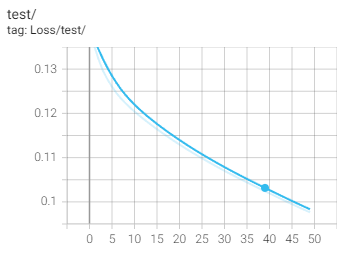

**Highway Network à 10 couches:**

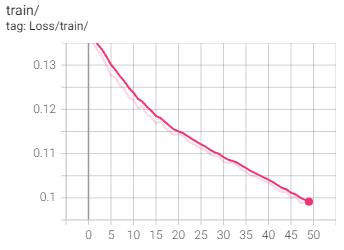
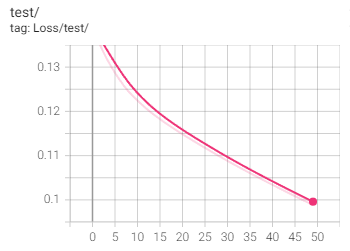

**Images reconstruites**

De gauche à droite: image initiale tirée de la base MNIST, reconstruction avec 5 couches, reconstruction avec 10 couches.

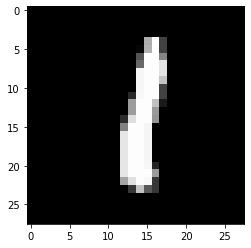
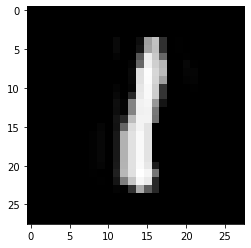
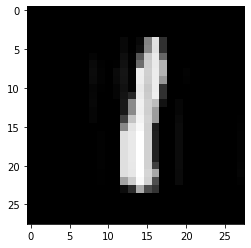


Nous observons que plus le nombre de couches est élevée, plus la loss est élevée. Elle est cependant moins élevée qu'elle l'aurait été pour un réseau classique avec autant de couches.